# Análise Weak Supervision

In [126]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# FA-KES

In [127]:
df = pd.read_csv('../../results/resultados_weak_supervision_fakes_train.csv')
df_test = pd.read_csv('../../results/resultados_weak_supervision_fakes_train.csv')

In [128]:
df_label = pd.read_csv('../../data/y_train_fakes.csv')
df_label_test = pd.read_csv('../../data/y_test_fakes.csv')

In [129]:
df.label.value_counts()

label
YES\n        2373
NO\n         2095
ABSTAIN\n     572
Name: count, dtype: int64

In [130]:
df_test.label.value_counts()

label
YES\n        2373
NO\n         2095
ABSTAIN\n     572
Name: count, dtype: int64

In [131]:
df['label'] = df['label'].str.rstrip('\n')
df_test['label'] = df_test['label'].str.rstrip('\n')

In [132]:
df_pivot = df.pivot(index = 'artigo', columns='sinal_credibilidade',values='label')
df_pivot_test = df.pivot(index = 'artigo', columns='sinal_credibilidade',values='label')

In [133]:
color_map = {'YES': 1, 'NO': -1, 'ABSTAIN': 0}
numeric_df = df_pivot.replace(color_map)
numeric_df_test = df_pivot_test.replace(color_map)

C:\Users\rafae\AppData\Local\Temp\ipykernel_4608\3209447135.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_df = df_pivot.replace(color_map)
C:\Users\rafae\AppData\Local\Temp\ipykernel_4608\3209447135.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_df_test = df_pivot_test.replace(color_map)


In [134]:
cmap = sns.color_palette(['red', 'white', 'green'], as_cmap=True)

In [135]:
numeric_df = numeric_df.reset_index()
numeric_df_test = numeric_df_test.reset_index()

In [136]:
numeric_df.drop(columns=['artigo'], inplace=True)
numeric_df_test.drop(columns=['artigo'], inplace=True)

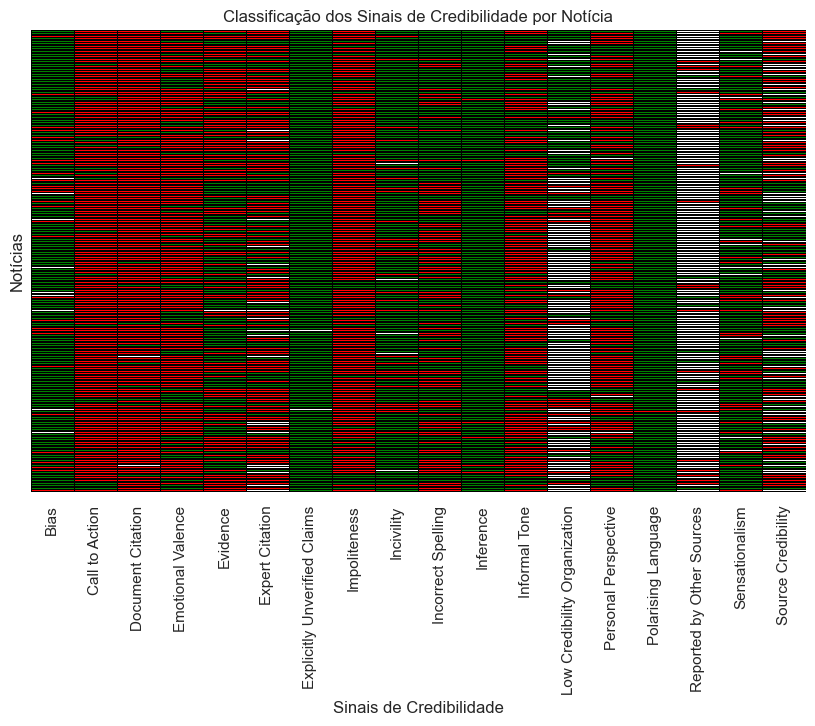

In [137]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    numeric_df[:300],
    cmap=cmap,
    cbar=False,
    linewidths=0.5,
    linecolor='black',
    xticklabels=True,
    yticklabels=False,
)
plt.xlabel('Sinais de Credibilidade')
plt.ylabel('Notícias')
plt.title('Classificação dos Sinais de Credibilidade por Notícia')


plt.show()

## Montando um Modelo

In [138]:
df_model = pd.concat([numeric_df, df_label], axis=1)
df_model_test = pd.concat([numeric_df_test, df_label_test], axis=1)

In [139]:
df_model.dropna(inplace=True)
df_model_test.dropna(inplace=True)

In [140]:
X = df_model.drop(columns=['label'])  # Features
y = df_model['label']            
X_test = df_model_test.drop(columns=['label'])
y_test = df_model_test['label']        

### Regressão Logística

In [141]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [142]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]
})

In [143]:
importance.sort_values('Importance', ascending=False)

,Feature,Importance
0,Bias,0.474659
17,Source Credibility,0.339892
9,Incorrect Spelling,0.274735
12,Low Credibility Organization,0.245090
10,Inference,0.223800
7,Impoliteness,0.133431
11,Informal Tone,0.103590
15,Reported by Other Sources,0.102190
16,Sensationalism,0.095809
4,Evidence,0.087283


In [144]:
probas = model.predict_proba(X_test)
preds = model.predict(X_test)

In [145]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.51      0.32      0.40        62
         1.0       0.48      0.67      0.56        58

    accuracy                           0.49       120
   macro avg       0.50      0.50      0.48       120
weighted avg       0.50      0.49      0.48       120



### XGBoost

In [146]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

d:\Rafael\MBA\TCC\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [147]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48        62
         1.0       0.48      0.55      0.52        58

    accuracy                           0.50       120
   macro avg       0.50      0.50      0.50       120
weighted avg       0.50      0.50      0.50       120



# FAKE BR.Corpus

In [148]:
df = pd.read_csv('../../results/resultados_weak_supervision_fakes_train.csv')
df_test = pd.read_csv('../../results/resultados_weak_supervision_fakes_train.csv')

In [149]:
df_label = pd.read_csv('../../data/y_train_fakes.csv')
df_label_test = pd.read_csv('../../data/y_test_fakes.csv')

In [150]:
df.label.value_counts()

label
YES\n        2373
NO\n         2095
ABSTAIN\n     572
Name: count, dtype: int64

In [151]:
df_test.label.value_counts()

label
YES\n        2373
NO\n         2095
ABSTAIN\n     572
Name: count, dtype: int64

In [152]:
df['label'] = df['label'].str.rstrip('\n')
df_test['label'] = df_test['label'].str.rstrip('\n')

In [153]:
df_pivot = df.pivot(index = 'artigo', columns='sinal_credibilidade',values='label')
df_pivot_test = df.pivot(index = 'artigo', columns='sinal_credibilidade',values='label')

In [154]:
color_map = {'YES': 1, 'NO': -1, 'ABSTAIN': 0}
numeric_df = df_pivot.replace(color_map)
numeric_df_test = df_pivot_test.replace(color_map)

C:\Users\rafae\AppData\Local\Temp\ipykernel_4608\3209447135.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_df = df_pivot.replace(color_map)
C:\Users\rafae\AppData\Local\Temp\ipykernel_4608\3209447135.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  numeric_df_test = df_pivot_test.replace(color_map)


In [155]:
cmap = sns.color_palette(['red', 'white', 'green'], as_cmap=True)

In [156]:
numeric_df = numeric_df.reset_index()
numeric_df_test = numeric_df_test.reset_index()

In [157]:
numeric_df.drop(columns=['artigo'], inplace=True)
numeric_df_test.drop(columns=['artigo'], inplace=True)

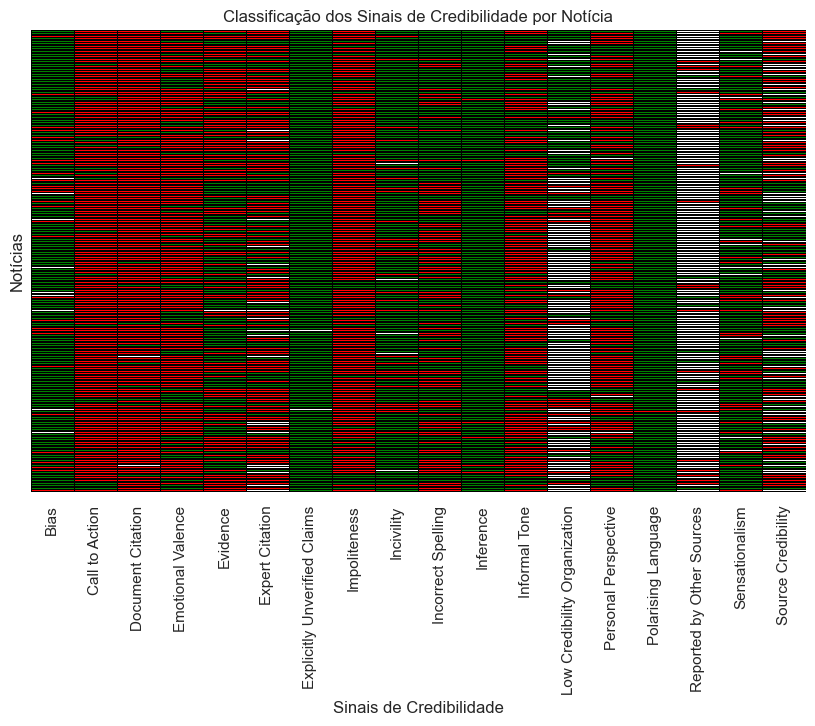

In [158]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    numeric_df[:300],
    cmap=cmap,
    cbar=False,
    linewidths=0.5,
    linecolor='black',
    xticklabels=True,
    yticklabels=False,
)
plt.xlabel('Sinais de Credibilidade')
plt.ylabel('Notícias')
plt.title('Classificação dos Sinais de Credibilidade por Notícia')


plt.show()

## Montando um Modelo

df_model = pd.concat([numeric_df, df_label], axis=1)
df_model_test = pd.concat([numeric_df_test, df_label_test], axis=1)

In [159]:
df_model.dropna(inplace=True)
df_model_test.dropna(inplace=True)

In [160]:
X = df_model.drop(columns=['label'])  # Features
y = df_model['label']            
X_test = df_model_test.drop(columns=['label'])
y_test = df_model_test['label'] 

### Regressão Logística

In [161]:
model = LogisticRegression()
model.fit(X, y)

LogisticRegression()

In [162]:
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.coef_[0]
})

In [163]:
importance.sort_values('Importance', ascending=False)

,Feature,Importance
0,Bias,0.474659
17,Source Credibility,0.339892
9,Incorrect Spelling,0.274735
12,Low Credibility Organization,0.245090
10,Inference,0.223800
7,Impoliteness,0.133431
11,Informal Tone,0.103590
15,Reported by Other Sources,0.102190
16,Sensationalism,0.095809
4,Evidence,0.087283


In [164]:
probas = model.predict_proba(X_test)
preds = model.predict(X_test)

In [165]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.51      0.32      0.40        62
         1.0       0.48      0.67      0.56        58

    accuracy                           0.49       120
   macro avg       0.50      0.50      0.48       120
weighted avg       0.50      0.49      0.48       120



### XGBoost

In [166]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X, y)

d:\Rafael\MBA\TCC\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:02:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [167]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.52      0.45      0.48        62
         1.0       0.48      0.55      0.52        58

    accuracy                           0.50       120
   macro avg       0.50      0.50      0.50       120
weighted avg       0.50      0.50      0.50       120



<Figure size 1000x800 with 0 Axes>

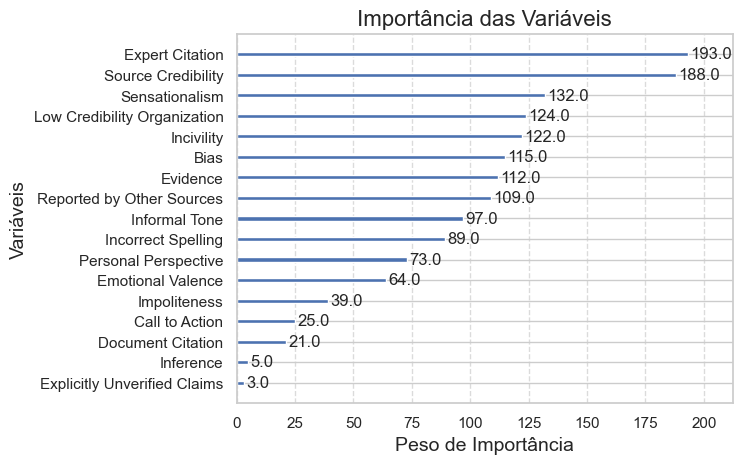

In [168]:
# Ajuste do estilo do Seaborn
sns.set(style='whitegrid')

# Configurando o tamanho da figura
plt.figure(figsize=(10, 8))

# Gerando o gráfico de importância das variáveis
plot_importance(model, importance_type='weight')

# Ajustando título e rótulos
plt.title('Importância das Variáveis', fontsize=16)
plt.xlabel('Peso de Importância', fontsize=14)
plt.ylabel('Variáveis', fontsize=14)

# Ajustando o layout para incluir o grid
plt.grid(True, axis='x', linestyle='--', alpha=0.7)  # Adiciona linhas do grid no eixo X

# Exibindo o gráfico
plt.show()